In [ ]:
password = "1234567890.As"

In [ ]:
import numpy as np

def trendline(index, data, order=1):
    coeffs = np.polyfit(index, list(data), order)
    slope = coeffs[-2]
    return float(slope)

index=[1,2,3,4]
List=[1043,6582,5452,7571]
resultent=trendline(index,List)
print(resultent)

1845.4000000000003


Correlació su de fruita

In [ ]:
import mysql.connector
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import ta

In [ ]:
def getPriceData(ticker, initial_date, period, db):
    ini_date = datetime.datetime.strptime(initial_date, "%d-%m-%Y")

    end_date = ini_date + datetime.timedelta(days=period)

    # query = 'SELECT {} FROM {} WHERE ticker=%s AND data_inici>=%s AND data_inici < %s'.format(columns, "preus") # string formatting method

    db.execute("SELECT * FROM preus " 
               "WHERE ticker=%s AND data_inici>=%s AND data_inici < %s", (ticker, ini_date, end_date))

    result = db.fetchall()
    df = pd.DataFrame(result, columns=('ticker', 'data_inici', 'data_final', 'open', 'high', 'low', 'close', 'volume'))
    df['data_inici'] = pd.to_datetime(df['data_inici'])  # set dates to datetime64
    df['data_inici'] = pd.to_datetime(df['data_final'])
    df.set_index('data_inici', inplace=True)
    return df

In [ ]:
def getCountryData(country_code, initial_date, period, db, columns=None):
    ini_date = datetime.datetime.strptime(initial_date, "%d/%m/%Y")

    end_date = ini_date + datetime.timedelta(days=period)

    db.execute("SELECT * FROM dades_paisos WHERE "
               "id_pais=%s AND data_inici>=%s AND data_inici < %s", (country_code, ini_date, end_date))

    result = db.fetchall()
    df = pd.DataFrame(result, columns=('id_pais', 'data_inici', 'data_final', 'PIB', 'IPC', 'deuta_publica'))
    df['data_inici'] = pd.to_datetime(df['data_inici'])  # set dates to datetime64
    df['data_final'] = pd.to_datetime(df['data_final'])
    df.set_index('data_inici', inplace=True)

    return df

In [ ]:
def getEventData(partial_title, db):
    title = '%' + partial_title + '%'
    
    db.execute("SELECT * FROM events " 
               "WHERE titular LIKE %s", (title,))
    
    result = db.fetchall()
    df = pd.DataFrame(result, columns=('id_event', 'titular', 'descripcio', 'data', 'tipus'))
    df['data'] = pd.to_datetime(df['data'])  # set dates to datetime64
    df.set_index('id_event', inplace=True)

    return df

In [ ]:
def getImportsData(pais_origen, pais_desti, initial_date, period, db, columns=None):
    ini_date = datetime.datetime.strptime(initial_date, "%d/%m/%Y")

    end_date = ini_date + datetime.timedelta(days=period)

    db.execute('SELECT * FROM imports WHERE id_pais_origen=%s AND id_pais_desti=%s AND data_inici>=%s AND data_inici < %s',
        (pais_origen, pais_desti, ini_date, end_date))

    result = db.fetchall()
    df = pd.DataFrame(result, columns=('ticker', 'data_inici', 'data_final', 'open', 'high', 'low', 'close', 'volume'))
    df['data_inici'] = pd.to_datetime(df['data_inici'])  # set dates to datetime64
    df['data_inici'] = pd.to_datetime(df['data_final'])
    df.set_index('data_inici', inplace=True)

    return df 

----------------------------------

# Correlacions

Per demostrar les diferents hipòtesis de correlacions, s'han fet dos funcions, una per calcular la matriu de correlacions entre diferents valors (calculate_corr_matrix) i l'altre per mostrar els resultats en forma de visual amb colors (plot_correlations).
Es calculen les taules de corelacions a través de la funcions de Pandas "corr", i s'usen els mètodes de Pearson i Spearman. En aquestes correlacions un resultat de 1, significa completament correlacionats, 0 és completament incorrelacionats i -1 és que tenen una correlació inversa.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# args = [nom_1,nom_2,....,nom_n],data1,data2,....., datan

def calculate_corr_matrix(*args):
    # Merge the dataframes based on the common identifier
    merged_df = pd.merge(args[1], args[2], on='data_inici')
    
    merged_df = merged_df.rename(columns={merged_df.columns[0]: args[0][0]})
    merged_df = merged_df.rename(columns={merged_df.columns[1]: args[0][1]})

    # Merge additional dataframes and rename columns
    for i in range(3, len(args)):
        merged_df = pd.merge(merged_df, args[i], on='data_inici')
        merged_df = merged_df.rename(columns={merged_df.columns[i-1]: args[0][i-1]})

    # Calculate Pearson correlation matrix
    pearson_matrix = merged_df.corr(method='pearson')
    
    # Calculate Spearman correlation matrix
    spearman_matrix = merged_df.corr(method='spearman')
    #print(pearson_matrix)
    #print(spearman_matrix)
    
    return [pearson_matrix,spearman_matrix]




In [ ]:
def plot_correlations(corr_matrix, tipus):
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create the heatmap using seaborn
    sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=ax, vmin=-1, vmax=1)

    # Customize the plot
    ax.set_title('Matriu de correlacions de ' + tipus)
    ax.set_xticklabels(corr_matrix.columns, rotation=45)
    ax.set_yticklabels(corr_matrix.columns, rotation=0)
    plt.show()


# Correlacions de diverses comodities

Ara calcularem les correlacions entre el petroli, el gas, la fusta i la soja, que ens serbiran per comprovar dos de les hipòtesis a mostrar:
- La fusta està correlacionada amb el petroli.
- El gas natural està correlacionat amb la soja.

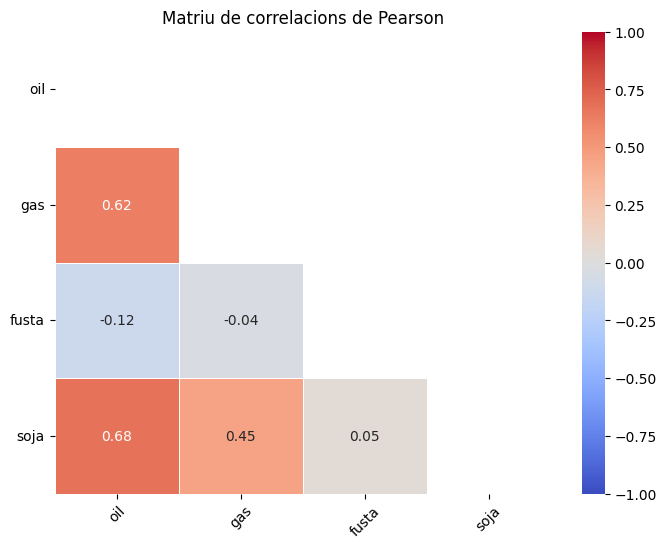

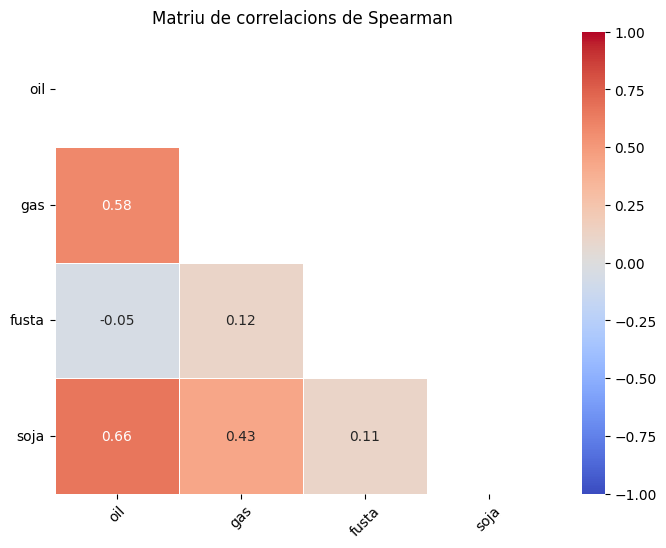

In [ ]:
#Agafem les dades de la base de dades

cnx = mysql.connector.connect(user="root", password=password, database="MercatoAnalisi")
cursor = cnx.cursor()


oil = getPriceData('CL=F', "01-01-2011", 3000, cursor)['close']
gas = getPriceData('NG=F', "01-01-2011", 3000, cursor)['close']
fusta = getPriceData('LBS=F', "01-01-2011", 3000, cursor)['close']
soja = getPriceData('ZM=F', "01-01-2011", 3000, cursor)['close']

cnx.commit()
cursor.close()

#calculem les matrius

vector_corr_matrix=calculate_corr_matrix(["oil","gas","fusta","soja"],oil,gas,fusta,soja)

#mostrem els resultats

plot_correlations(vector_corr_matrix[0],"Pearson")
plot_correlations(vector_corr_matrix[1],"Spearman")



En els gràfics mostrats, es pot observar més informació que la que necessitem per a comprovar les nostres hipòtesis, anem a centrar-nos en la informació rellevant:
- La fusta està correlacionada amb el petroli. És una hiòtesis errònia segons els resultats obtinguts, ja que la correlació entre la fusta i el petroli segons Pearson és de -0.12 i segons Spearman és de -0.5, que són valors molt pròxims a 0 i per tant, no estan correlacionas.
- El gas natural està correlacionat amb la soja. És una hipòtesis que podem dir que estan força correlacionas, i per tant errònia, ja que s'han obtingut valors de correlació de 0.45 i 0.43 de Pearson i Spearman respectivament. 

# Correlació entre PIB anglès post brexit amb el PIB Europeu

Ara calcularem la correlació entre el PIB anglès i el PIB Europeu que ens serbiran per comprovar la següent hipòtesis:
-  El PIB anglès no està correlacionat amb el PIB Europeu post brexit

In [ ]:
def getEuropeanCountriesData(initial_date, period, db):
    ini_date = datetime.datetime.strptime(initial_date, "%d/%m/%Y")

    end_date = ini_date + datetime.timedelta(days=period)

    db.execute("SELECT d.id_pais,d.data_inici,d.data_final,d.PIB,d.IPC,d.deuta_publica FROM "
               "dades_paisos d JOIN paisos p ON d.id_pais = p.id_pais "
               "WHERE p.continent = 'Europa' AND data_inici>=%s AND data_inici<%s ", (ini_date, end_date))

    result = db.fetchall()
    df = pd.DataFrame(result, columns=('id_pais', 'data_inici', 'data_final', 'PIB', 'IPC', 'deuta_publica'))
    return df


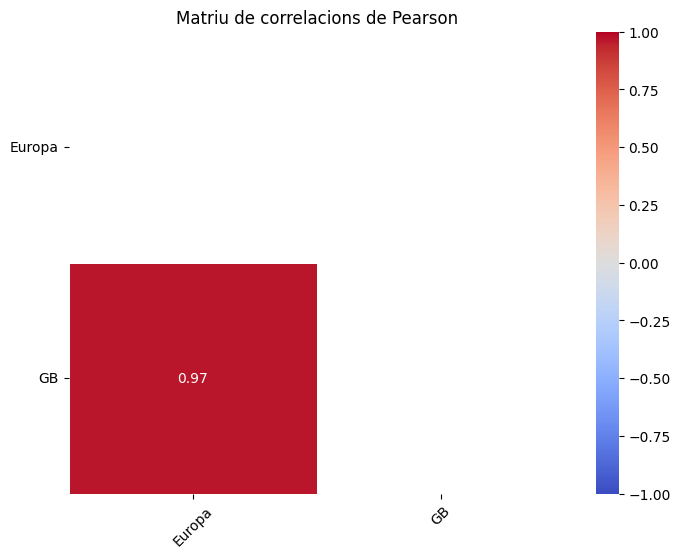

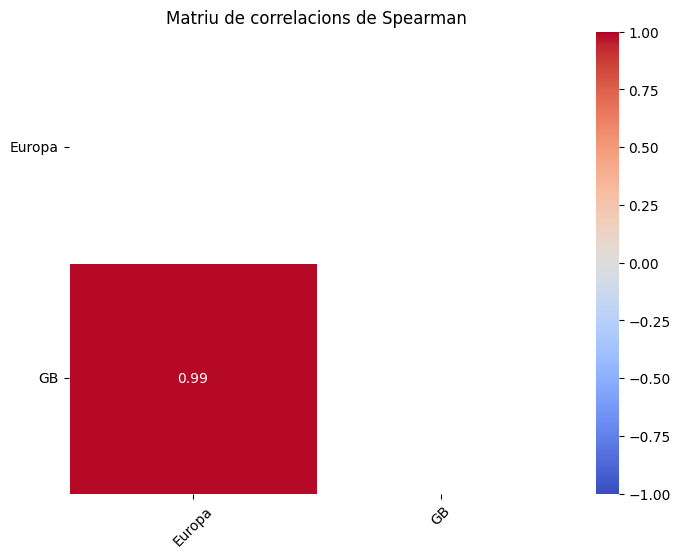

In [ ]:
cnx = mysql.connector.connect(user="root", password=password, database="MercatoAnalisi")
cursor = cnx.cursor()

df = getEuropeanCountriesData("01/01/2020", 999, cursor)
pib_europeu = df[["data_inici","PIB"]]
pib_europeu = pib_europeu.groupby("data_inici").sum()['PIB']
pib_europeu.index = pd.to_datetime(pib_europeu.index)
PIB_Great_britain = getCountryData("GB","01/01/2020", 999, cursor)['PIB']

cnx.commit()
cursor.close()


#calculem les matrius

vector_corr_matrix = calculate_corr_matrix(["Europa","GB"],pib_europeu,PIB_Great_britain)


#mostrem els resultats

plot_correlations(vector_corr_matrix[0],"Pearson")
plot_correlations(vector_corr_matrix[1],"Spearman")




El resultat és molt clar, el PIB anglès i l'Europeu, estan estretament coorelacionats amb uns coeficients de corelació de 0.97 i 0.99 de pearson i spearman respectivament. Per tant, la hipòtesi ha refutad, ja que estan estretament relacionats.

# Correlció entre preu del petroli i IPC global

Ara calcularem la correlació entre el petroli i l'IPC global que ens serbiran per comprovar la següent hipòtesis:
-  El petroli està correlacionat amb el l’IPC global. Per a fer-ho, hem utilitzat una simplificació degut a una manca de dades, hem simplificat l'IPC global fent la mitjana entre l'IPC d'Estats Units, Alemania, Espanya, Russia, Anglaterra.

In [ ]:
"""
def getCountryDataNoDF(country_code, initial_date, period, db, columns=None):
    ini_date = datetime.datetime.strptime(initial_date, "%d/%m/%Y")

    end_date = ini_date + datetime.timedelta(days=period)

    db.execute("SELECT * FROM dades_paisos WHERE "
               "id_pais=%s AND data_inici>=%s AND data_inici < %s", (country_code, ini_date, end_date))

    result = db.fetchall()
    df = pd.DataFrame(result, columns=('id_pais', 'data_inici', 'data_final', 'PIB', 'IPC', 'deuta_publica'))

    return df

countries = ["US", "GB", "ES", "CA", "RU", "DE"]

dfs = []
for cc in countries:
    dfs.append(getCountryDataNoDF(cc, "01/01/2010", 99999, cursor))
    

alldata = pd.concat(dfs)
df4  = alldata[["data_inici", "IPC"]]
#[["data_inici", "IPC"]]
df4.groupby("data_inici").mean()
"""

def getWorldIPC(initial_date, period, db, columns=None):
    ini_date = datetime.datetime.strptime(initial_date, "%d/%m/%Y")

    end_date = ini_date + datetime.timedelta(days=period)

    db.execute("SELECT data_inici,avg(IPC) FROM dades_paisos "
               "WHERE id_pais IN ('US', 'GB', 'ES', 'CA', 'RU', 'DE')  "
               "GROUP BY data_inici "
               "HAVING data_inici>=%s AND data_inici < %s", (ini_date, end_date))

    result = db.fetchall()
    df = pd.DataFrame(result, columns=('data_inici', 'ipc_avg'))
    df['data_inici'] = pd.to_datetime(df['data_inici'])  # set dates to datetime64
    df.set_index('data_inici', inplace=True)

    return df["ipc_avg"]

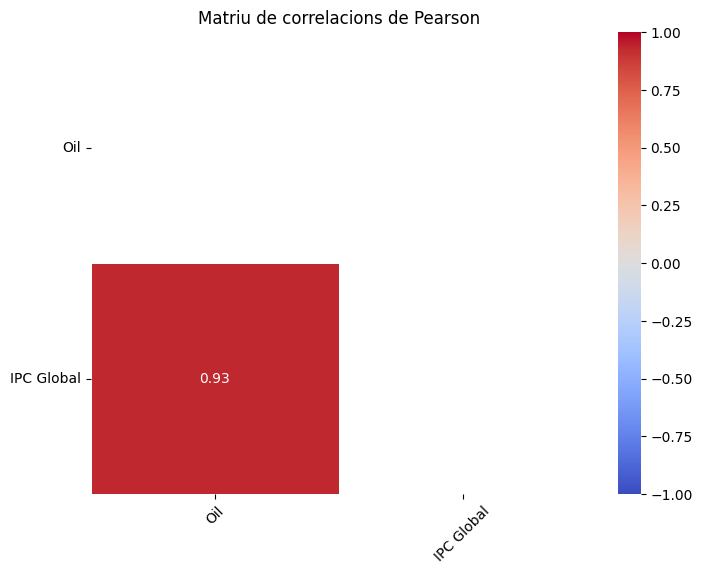

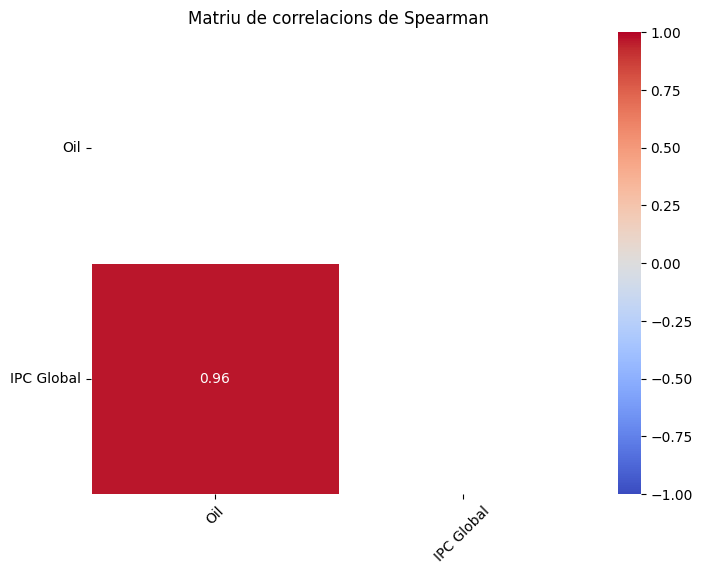

In [ ]:
cnx = mysql.connector.connect(user="root", password=password, database="MercatoAnalisi")
cursor = cnx.cursor()

world_IPC = getWorldIPC("01/01/2010", 9999, cursor)
oil = getPriceData('CL=F', "01-01-2016", 9999, cursor)['close']

cnx.commit()
cursor.close()

#group values by month
oil.index = pd.to_datetime(oil.index) 
oil = oil.groupby(pd.Grouper(freq='M')).mean()
oil.index = oil.index.to_period('M').to_timestamp('D')

#Match index
oil = oil.drop(index=oil.index.difference(world_IPC.index))

#print(oil.to_string())

#calculem les matrius

vector_corr_matrix = calculate_corr_matrix(["Oil","IPC Global"],oil,world_IPC)


#mostrem els resultats

plot_correlations(vector_corr_matrix[0],"Pearson")
plot_correlations(vector_corr_matrix[1],"Spearman")




El resultat és molt clar, L'IPC Global i el preu del petroli, estan estretament coorelacionats amb uns coeficients de corelació de 0.93 i 0.96 de pearson i spearman respectivament.  Per tant, la hipòtesi ha estat verificada com a certa.

-----------------------